<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S5/6-MNIST-DataTransforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install the dependencies


In [12]:
!pip install torchsummary

### Import dependencies

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

### Helper utilities

In [178]:
def isCuda():
  return torch.cuda.is_available()

def randInt(min, max, size): 
  return torch.LongTensor(size).random_(min, max)

def getDevice(): 
  return torch.device("cuda" if isCuda() else "cpu")

def showImages(images, labels, cols=10): 
  figure = plt.figure()
  num_of_images = len(images)
  rows = np.ceil(num_of_images/float(cols))
  for index in range(0, num_of_images):
    plt.subplot(rows, cols, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r') 

cpu = torch.device("cpu")
device = getDevice()
print(f'\nDevice: {device}')

# Set seed 
seed =1 
torch.manual_seed(seed)
if isCuda():
  torch.cuda.manual_seed(seed)



Device: cuda


### Transformations for Train and Test

In [0]:
def train_transformations(): 
  return transforms.Compose([         
                    transforms.RandomRotation((-7.0, 7.0), fill=(1,)), 
                    transforms.ToTensor(), 
                    transforms.Normalize((0.1307,), (0.3081,))])
  
def test_transformations(): 
  return transforms.Compose([
                    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

### Load train and test data

In [213]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if isCuda() else dict(shuffle=True, batch_size=64)

train_data = datasets.MNIST("../data", train=True, transform=train_transformations(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

test_data = datasets.MNIST("../data", train=False, transform=test_transformations(), download=True)
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

print(f'\nSize of train data:{train_data.data.shape}')
print(f'\nSize of test data:{test_data.data.shape}')


Size of train data:torch.Size([60000, 28, 28])

Size of test data:torch.Size([10000, 28, 28])


### View training/test data and their statistics


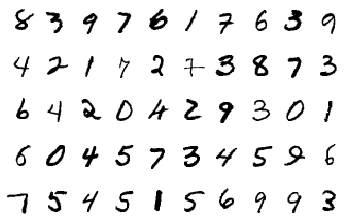

In [214]:
randImages = randInt(0, len(test_data.data), 50)
showImages(test_data.data[randImages], test_data.targets[randImages])

### Network architecture

In [220]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()

    drop_out = 0.04
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(), 
        nn.BatchNorm2d(10),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out)
    ) # Output - 24 x 24

    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        nn.MaxPool2d(2, 2)
    ) # Output - 14 x 14

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=15, kernel_size=(3, 3), padding=0, bias=False), 
        nn.ReLU()
    ) # output = 6 x 6

    self.gap1 = nn.AdaptiveAvgPool2d(1)
    self.conv4 = nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), bias=False)

  def forward(self, x): 

    x = self.transition1(self.conv1(x))
    x = self.conv2(x)
    x = self.conv4(self.gap1(x))
    x = x.view(-1, 10)
    return F.log_softmax(x)

  def summarize(self, input): 
    summary(self, input_size=input)

Net().to(getDevice()).summarize((1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
        Dropout2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Utilities to compute metrics

In [0]:
def compute_accuracy(prediction, target): 
  return 100 * prediction.eq(target.view_as(prediction)).sum().item() / float(len(prediction))

def compute_metrics(data, prediction, target): 
  corrects = prediction.eq(target.view_as(prediction))
  accuracy = corrects.sum().item() / len(prediction)
  miss_indices = ~corrects
  miss_data = data[miss_indices]  
  miss_predictions = prediction[miss_indices]
  miss_targets = target[miss_indices]
  print(confusion_matrix(target.to(cpu), prediction.to(cpu)))
  return accuracy * 100, (miss_data, miss_predictions, miss_targets)

### Code to train the model

In [0]:
def train_one_batch(model, data, target, optimizer): 
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target)
  loss.backward()
  optimizer.step()
  return (loss, output.argmax(dim=1))

def train_one_epoch(model, train_loader, optimizer, device=getDevice()): 
  model.train()
  pbar = tqdm(train_loader, ncols=1000) 
  wholePred = []
  wholeData = []
  wholeTarget = []
  for idx, (data, target) in enumerate(pbar): 
    data, target = data.to(device), target.to(device)
    (loss, prediction) = train_one_batch(model, data, target, optimizer)
    accuracy = compute_accuracy(prediction, target)
    pbar.set_description(desc= f'Loss={loss.item()}\t id={idx}\t accuracy={accuracy}')
    wholePred.append(prediction)
    wholeData.append(data)
    wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred))

### Code to test the model

In [0]:
def test_one_batch(model, data, target): 
  output = model(data)
  loss = F.nll_loss(output, target)  
  return (loss, output.argmax(dim=1))
  
def test(model, test_loader, device=getDevice()): 
  model.eval()
  pbar = tqdm(test_loader, ncols=1000)
  wholePred = []
  wholeData = []
  wholeTarget = []
  with torch.no_grad(): 
    for idx, (data, target) in enumerate(pbar): 
      data, target = data.to(device), target.to(device)
      (loss, prediction) = test_one_batch(model, data, target)
      accuracy = compute_accuracy(prediction, target)
      pbar.set_description(desc= f'Loss={loss.item()}\t id={idx}\t accuracy={accuracy}%')
      wholePred.append(prediction)
      wholeData.append(data)
      wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred))

### Build the model by training and testing. 

In [224]:
def build(model, train_loader, optimizer, epoch):
  train_accs = []
  test_accs = [] 
  for e in range(0, epoch): 
    print(f'\n\nEpoch: {e + 1}')
    (train_data, train_target, train_prediction) = train_one_epoch(model, train_loader, optimizer)
    trainAcc = compute_accuracy(train_prediction, train_target)
    train_accs.append(trainAcc)
    print(f'Train Accuracy: {trainAcc}%')
    (test_data, test_target, test_prediction) = test(net, test_loader)
    testAcc = compute_accuracy(test_prediction, test_target)
    test_accs.append(testAcc)
    print(f'Test Accuracy: {testAcc}%')
  return(train_accs, test_accs)

net = Net().to(getDevice())
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
(train_accs, test_accs) = build(net, train_loader, optimizer, 15)



Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy: 83.83333333333333%


Test Accuracy: 98.13%


Epoch: 2


Train Accuracy: 97.18833333333333%


Test Accuracy: 98.84%


Epoch: 3


Train Accuracy: 97.935%


Test Accuracy: 98.94%


Epoch: 4


Train Accuracy: 98.11166666666666%


Test Accuracy: 99.11%


Epoch: 5


Train Accuracy: 98.255%


Test Accuracy: 99.05%


Epoch: 6


Train Accuracy: 98.47166666666666%


Test Accuracy: 99.21%


Epoch: 7


Train Accuracy: 98.695%


Test Accuracy: 99.29%


Epoch: 8


Train Accuracy: 98.63833333333334%


Test Accuracy: 99.34%


Epoch: 9


Train Accuracy: 98.71333333333334%


Test Accuracy: 99.23%


Epoch: 10


Train Accuracy: 98.81666666666666%


Test Accuracy: 99.42%


Epoch: 11


Train Accuracy: 98.79%


Test Accuracy: 99.29%


Epoch: 12


Train Accuracy: 98.85833333333333%


Test Accuracy: 99.43%


Epoch: 13


Train Accuracy: 98.905%


Test Accuracy: 99.45%


Epoch: 14


Train Accuracy: 98.94833333333334%


Test Accuracy: 99.34%


Epoch: 15


Train Accuracy: 98.905%


Test Accuracy: 99.4%


Text(0.5, 1.0, 'Test Accuracy')

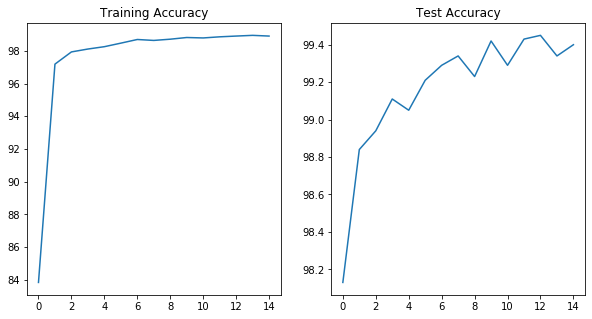

In [225]:
fig, axs = plt.subplots(1,2,figsize=(10, 5))
axs[0].plot(train_accs)
axs[0].set_title("Training Accuracy")
axs[1].plot(test_accs)
axs[1].set_title("Test Accuracy")

## Target 

Based on the misclassifications, the goal is to increase the accuracy by trying data transforms. 

## Result 

* Parameters = 9,876
* Best train accuracy = 98.94%
* Best validation accuracy = 99.45%

## Analysis 

* Though the test accuracy was greater than 99.4% for 4 epochs, from the graph it can be seen that the accuracy is fluctuating. We still have to improve the model to stabilize the same across epochs. 
